# DS405 Machine Learning Applications in Business and Economics Mini-Project
---

<font color="red">TBD: 
- Preprocessing of data
    - Delivery Delay?
    - What features to include/leave out entirely?

- One-hot encoding of features
    - surrogate model splits as if continuous
    - do black-box models also do this?
    
- Comparison of categorical/binary/continuous variables in LIME

</font>


## Introduction

In the realm of e-commerce, a common observation is that a significant proportion of customers engage in a single transaction and then cease further purchases. This phenomenon can be attributed to a multitude of factors. To mitigate this, e-commerce platforms employ a variety of strategies aimed at fostering customer loyalty. One such strategy involves the distribution of discount vouchers subsequent to the initial purchase, with the goal of incentivizing repeat transactions. However, indiscriminate distribution of these vouchers may not be an optimal strategy. This is because a segment of customers might have engaged in repeat purchases even in the absence of such incentives. Consequently, the redemption of these vouchers by such customers translates into a reduction in the retailer’s profit. Empirical analyses conducted by the media retailer have demonstrated that for 10% of non-buyers, the voucher instigates a purchase with an average order value of €20. Thus, if a voucher is dispatched to a customer who would not have actually made another purchase, the revenue increases by an average of €1.5. On the other hand, sending a voucher to a customer who would have made a purchase anyway results in a revenue loss equivalent to the voucher value of €5. For customers who don’t receive a voucher, there is no impact on revenues. Therefore, it is crucial to devise a more targeted approach for the distribution of these vouchers.

## Task 

The task at hand involves constructing a predictive model that leverages various features associated with a customer’s initial order. The objective is to determine whether a €5.00 voucher should be issued to a specific customer. Detailed descriptions of these features can be found in the data dictionary.pdf file.
The model should be designed to predict if a customer will place a subsequent order within a 90-day period following their initial purchase. This information is represented by the target90 variable in the dataset. The model’s performance is evaluated based on the expected revenue across all customers in a given dataset. This is computed by considering the model’s predictions in conjunction with the associated costs and revenues. It’s crucial to note that the model’s effectiveness is directly tied to its ability to maximize this expected revenue. Hence, the model should be optimized with this specific goal in mind.


---

In [35]:
# Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Binary dependent variable
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from datetime import datetime
from xgboost import XGBClassifier
import joblib # to save trained model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import shap 
import dill # to save workspace
from sklearn.inspection import permutation_importance # permutation feature importance for global interpretability
from sklearn.inspection import PartialDependenceDisplay as pdp # partial dependence plots for global interpretability
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import plot_tree
from lime import lime_tabular # Local interpratble model agonstic explanations
import shap # SHAP values for local interpretability
import seaborn as sns

In [36]:
# Separator is ;
data = pd.read_csv("train.csv", sep = ";")

# Dataset is wide, print all rows and only first 15 columns
data.describe().iloc[:,0:15]

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


customernumber    salutation         title        domain    newsletter  \
count    32428.000000  32428.000000  32428.000000  32428.000000  32428.000000   
mean     33389.298569      0.541569      0.006969      7.517115      0.169483   
std      19148.090449      0.657044      0.083192      3.683945      0.375184   
min          1.000000      0.000000      0.000000      0.000000      0.000000   
25%      16802.750000      0.000000      0.000000      4.000000      0.000000   
50%      33552.500000      0.000000      0.000000      9.000000      0.000000   
75%      50034.250000      1.000000      0.000000     11.000000      0.000000   
max      66251.000000      2.000000      1.000000     12.000000      1.000000   

              model   paymenttype  deliverytype  invoicepostcode  \
count  32428.000000  32428.000000  32428.000000     32428.000000   
mean       1.646910      1.000987      0.201955        48.752282   
std        0.825981      1.092677      0.401465        24.361425   
min        1.000000      0.000000      0.000000         0.000000   
25%        1.000000      0.000000      0.000000        30.000000   
50%        1.000000      1.000000      0.000000        47.000000   
75%        2.000000      2.000000      0.000000        66.000000   
max        3.000000      3.000000      1.000000        99.000000   

            voucher          case   numberitems          gift         entry  \
count  32428.000000  32428.000000  32428.000000  32428.000000  32428.000000   
mean       0.162020      2.934378      2.019551      0.004564      0.414642   
std        0.368475      1.319270      1.726046      0.067404      0.492668   
min        0.000000      1.000000      1.000000      0.000000      0.000000   
25%        0.000000      2.000000      1.000000      0.000000      0.000000   
50%        0.000000      3.000000      1.000000      0.000000      0.000000   
75%        0.000000      4.000000      2.000000      0.000000      1.000000   
max        1.000000      5.000000     50.000000      1.000000      1.000000   

        points  
count  32428.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0

In [37]:
# Second half of the columns
# Dataset is wide, print all rows and only remaining columns
data.describe().iloc[:,15:]

shippingcosts        weight          remi        cancel          used  \
count   32428.000000  32428.000000  32428.000000  32428.000000  32428.000000   
mean        0.150611    637.920809      0.059979      0.061613      0.068860   
std         0.357674    724.358131      0.388740      0.306833      0.474444   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.000000      3.000000      0.000000      0.000000      0.000000   
50%         0.000000    494.000000      0.000000      0.000000      0.000000   
75%         0.000000    920.000000      0.000000      0.000000      0.000000   
max         1.000000  20076.000000     19.000000     17.000000     19.000000   

                 w0            w1            w2            w3            w4  \
count  32428.000000  32428.000000  32428.000000  32428.000000  32428.000000   
mean       0.902122      0.404342      0.276644      0.018903      0.047027   
std        1.654767      1.410395      1.353981      0.253596      0.434265   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000      0.000000   
max       99.000000     84.000000     90.000000     15.000000     36.000000   

                 w5            w6            w7            w8            w9  \
count  32428.000000  32428.000000  32428.000000  32428.000000  32428.000000   
mean       0.180986      0.027908      0.023128      0.000185      0.164981   
std        0.561751      0.299862      0.401782      0.013601      0.836705   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       14.000000     27.000000     55.000000      1.000000     48.000000   

                w10      target90  
count  32428.000000  32428.000000  
mean       0.092883      0.186598  
std        0.610509      0.389594  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max       50.000000      1.000000

Every column has a count of 32428 -> No missing values seem to be present. In the case of binary encoded variables, the mean directly reflects a percentage (if multiplied by 100). \
However, due to their datatype, some columns are not present in the .describe()-dataframe. Therefore, to fully detect all missing values, we loop over all columns in the as follows:

In [38]:
print(f"Only {np.round(data['target90'].mean()*100,2)}% of customers in the data set repurchased in the next 90 days. This makes the data set imbalanced and we have to proceed with caution.")

Only 18.66% of customers in the data set repurchased in the next 90 days. This makes the data set imbalanced and we have to proceed with caution.


---

### Visualization of feature distribution

In [39]:
data.columns

### 9 left out features in the lists below
## nominal
# customernumber
# invoicepostcode
# delivpostcode
# advertisingdatacode
# target90 

## cardinal
# deliverydatepromised
# deliverydatereal
# datecreated
# date

Index(['customernumber', 'date', 'salutation', 'title', 'domain',
       'datecreated', 'newsletter', 'model', 'paymenttype', 'deliverytype',
       'invoicepostcode', 'delivpostcode', 'voucher', 'advertisingdatacode',
       'case', 'numberitems', 'gift', 'entry', 'points', 'shippingcosts',
       'deliverydatepromised', 'deliverydatereal', 'weight', 'remi', 'cancel',
       'used', 'w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9',
       'w10', 'target90'],
      dtype='object')

In [40]:
nominal_features = ["salutation", "title", "domain", "newsletter", "model", "paymenttype", "deliverytype", "voucher", "gift", "entry", "points", "shippingcosts"] # target90 left out as well 
cardinal_features = ["numberitems", "weight", "remi", "cancel", "used", "w0", "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10"]
ordinal_features = ["case"]

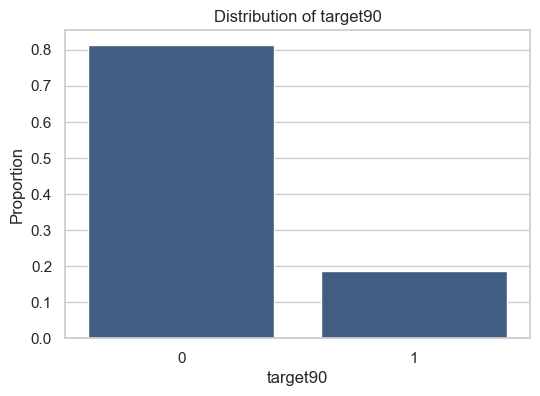

In [41]:
# Draw distribution of target90 variable in data
plt.figure(figsize=(6, 4))

# Count the occurrences of target category
counts = data['target90'].value_counts(normalize=True).reset_index(name='count')

# Plot the count plot
sns.barplot(x='target90', y='count', data=counts, color="#365c8d")

plt.title(f"Distribution of target90")
plt.xlabel('target90')
plt.ylabel('Proportion')
plt.show()

- Distribution of nominal features with respect to target90

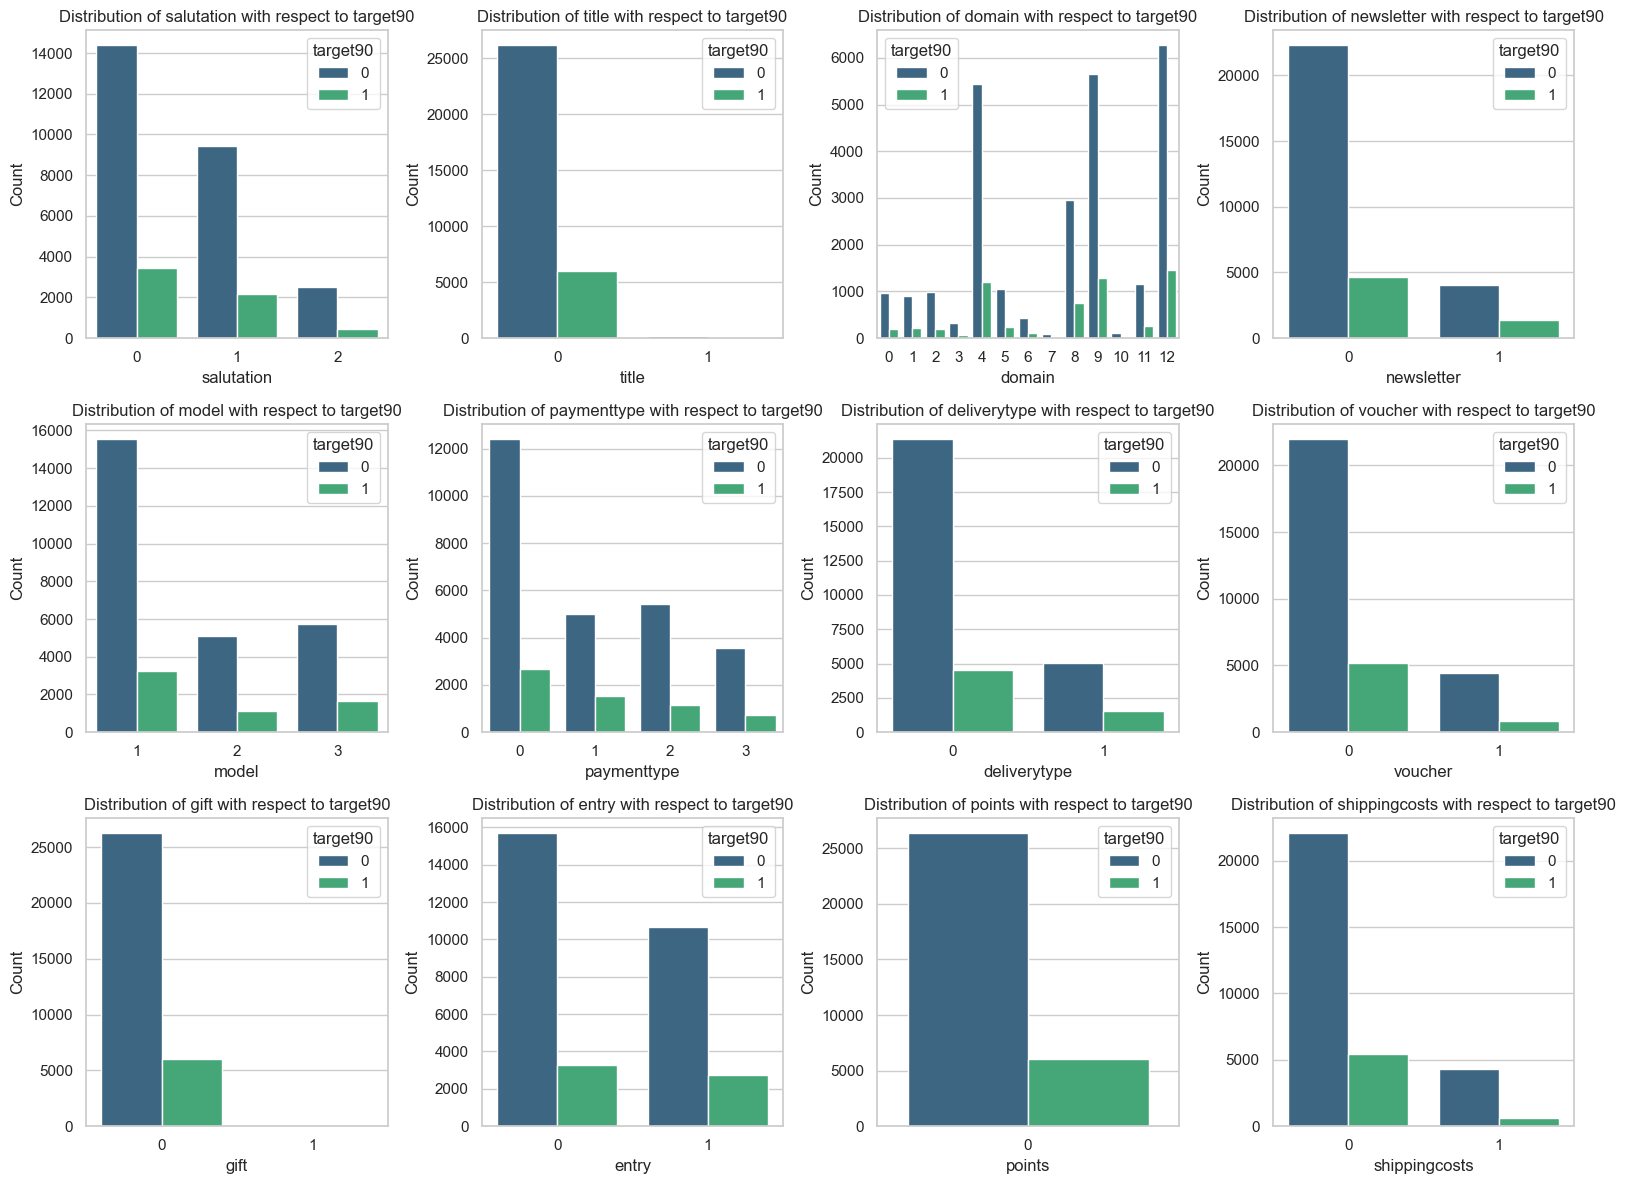

In [42]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each nominal feature and create bar plots
for i, feature in enumerate(nominal_features):
    sns.countplot(x=feature, hue='target90', data=data, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} with respect to target90')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='target90')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

- Distribution of cardinal features with respect to target90

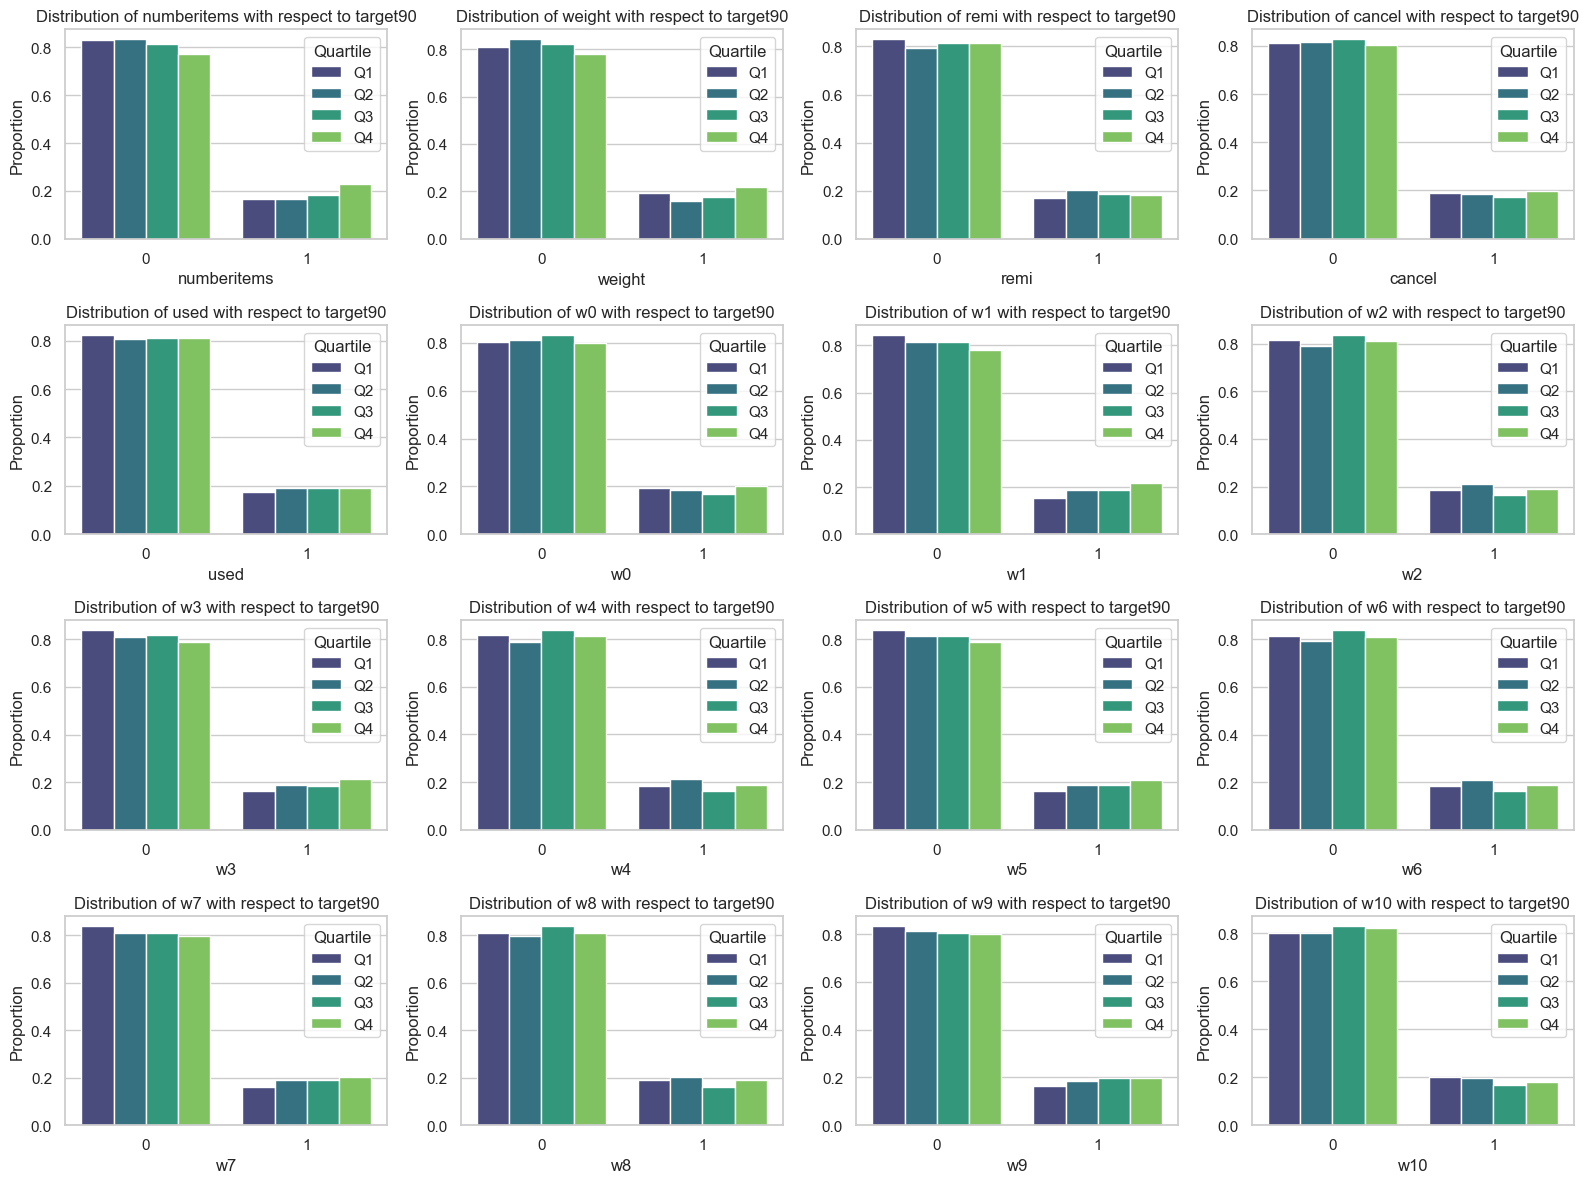

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'data' is your DataFrame and 'cardinal_features' is the list of features
# Update 'target90' with your actual target column name

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each nominal feature and create countplots for quartiles
for i, feature in enumerate(cardinal_features):

    # Sort data according to feature
    data = data.sort_values(feature)

    # Get data in 25% slides
    data_25 = data.iloc[:int(0.25 * len(data))]
    data_50 = data.iloc[int(0.25 * len(data)):int(0.5 * len(data))]
    data_75 = data.iloc[int(0.5 * len(data)):int(0.75 * len(data))]
    data_100 = data.iloc[int(0.75 * len(data)):]

    # Compute share of target90 = 1 in each quartile
    data_25_y_1 = data_25['target90'].mean()
    data_50_y_1 = data_50['target90'].mean()
    data_75_y_1 = data_75['target90'].mean()
    data_100_y_1 = data_100['target90'].mean()

    # Compute share of target90 = 0 in each quartile
    data_25_y_0 = 1 - data_25_y_1
    data_50_y_0 = 1 - data_50_y_1
    data_75_y_0 = 1 - data_75_y_1
    data_100_y_0 = 1 - data_100_y_1

    # Create a DataFrame with the computed values
    df = pd.DataFrame({'target90': ['0', '1'], 'Q1': [data_25_y_0, data_25_y_1], 'Q2': [data_50_y_0, data_50_y_1],
                        'Q3': [data_75_y_0, data_75_y_1], 'Q4': [data_100_y_0, data_100_y_1]})
    # Plot the results
    sns.barplot(x='target90', y='value', hue='variable', data=pd.melt(df, ['target90']), ax=axes[i], palette = 'viridis')
    axes[i].set_title(f'Distribution of {feature} with respect to target90')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Quartile')
    

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [44]:
df

target90        Q1        Q2        Q3        Q4
0        0  0.799803  0.801653  0.831134  0.821019
1        1  0.200197  0.198347  0.168866  0.178981

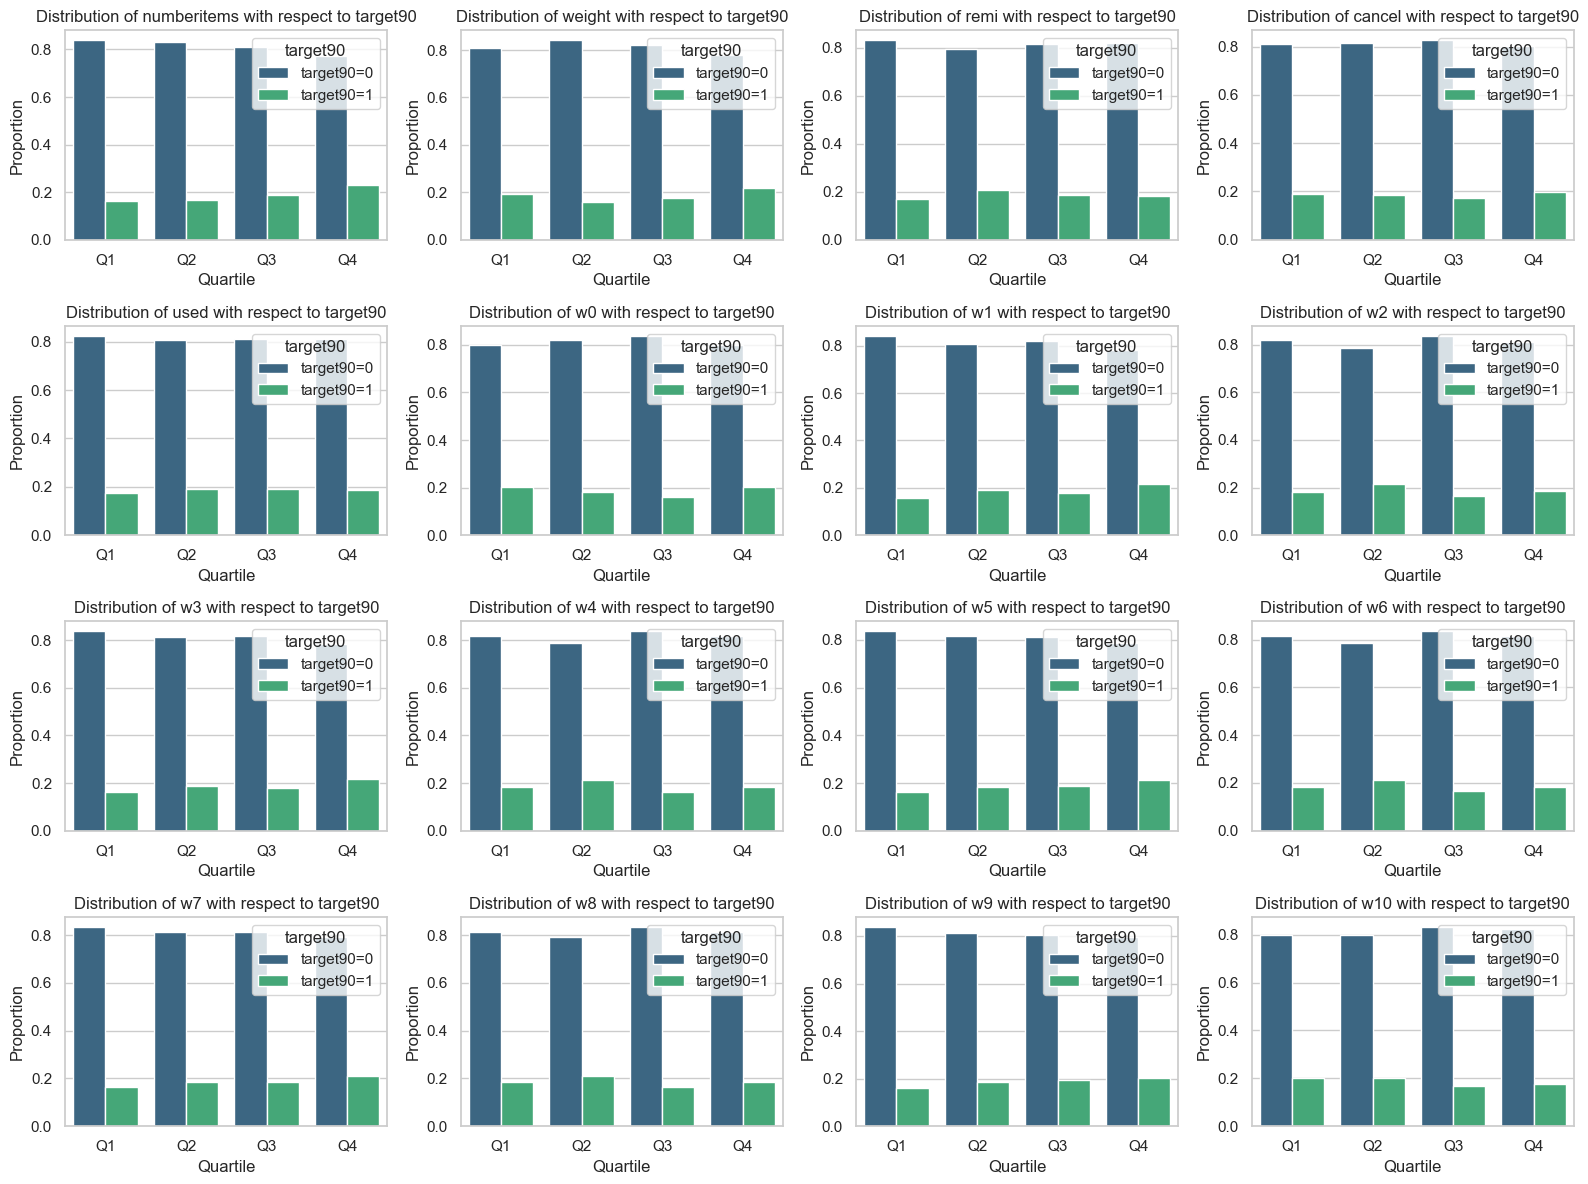

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'data' is your DataFrame and 'cardinal_features' is the list of features
# Update 'target90' with your actual target column name

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each nominal feature and create countplots for quartiles
for i, feature in enumerate(cardinal_features):

    # Sort data according to feature
    data = data.sort_values(feature)

    # Get data in 25% slides
    data_25 = data.iloc[:int(0.25 * len(data))]
    data_50 = data.iloc[int(0.25 * len(data)):int(0.5 * len(data))]
    data_75 = data.iloc[int(0.5 * len(data)):int(0.75 * len(data))]
    data_100 = data.iloc[int(0.75 * len(data)):]

    # Compute share of target90 = 1 in each quartile
    data_25_y_1 = data_25['target90'].mean()
    data_50_y_1 = data_50['target90'].mean()
    data_75_y_1 = data_75['target90'].mean()
    data_100_y_1 = data_100['target90'].mean()

    # Compute share of target90 = 0 in each quartile
    data_25_y_0 = 1 - data_25_y_1
    data_50_y_0 = 1 - data_50_y_1
    data_75_y_0 = 1 - data_75_y_1
    data_100_y_0 = 1 - data_100_y_1

    # Create a DataFrame with the computed values
    df = pd.DataFrame({'Quartile': ['Q1', 'Q2', 'Q3', 'Q4'],
                       'target90=0': [data_25_y_0, data_50_y_0, data_75_y_0, data_100_y_0],
                       'target90=1': [data_25_y_1, data_50_y_1, data_75_y_1, data_100_y_1]})

    # Melt the DataFrame for better visualization
    melted_df = pd.melt(df, id_vars='Quartile', var_name='target90', value_name='Proportion')

    # Plot the results
    sns.barplot(x='Quartile', y='Proportion', hue='target90', data=melted_df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {feature} with respect to target90')
    axes[i].set_xlabel('Quartile')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='target90')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [46]:
df

Quartile  target90=0  target90=1
0       Q1    0.796842    0.203158
1       Q2    0.799556    0.200444
2       Q3    0.832614    0.167386
3       Q4    0.824596    0.175404

---

- Preprocessing for one hot encoding

In [47]:
# Domain
for i in range(len(data["domain"])):
    value = data["domain"].iloc[i]
    if value == 0:
        data.loc[i, "domain"] = "aol.com"
    elif value == 1:
        data.loc[i, "domain"] = "arcor.de"
    elif value == 2:
        data.loc[i, "domain"] = "freenet.de"
    elif value == 3:
        data.loc[i, "domain"] = "gmail.com"
    elif value == 4:
        data.loc[i, "domain"] = "gmx.de"
    elif value == 5:
        data.loc[i, "domain"] = "hotmail.de"
    elif value == 6:
        data.loc[i, "domain"] = "online.de"
    elif value == 7:
        data.loc[i, "domain"] = "onlinehome.de"
    elif value == 8:
        data.loc[i, "domain"] = "t-online.de"
    elif value == 9:
        data.loc[i, "domain"] = "web.de"
    elif value == 10:
        data.loc[i, "domain"] = "yahoo.com"
    elif value == 11:
        data.loc[i, "domain"] = "yahoo.de"
    elif value == 12:
        data.loc[i, "domain"] = "others"

# Salutation
for i in range(len(data["salutation"])):
    value = data["salutation"].iloc[i]
    if value == 0:
        data.loc[i, "salutation"] = "Ms."
    elif value == 1:
        data.loc[i, "salutation"] = "Mr."
    elif value == 2:
        data.loc[i, "salutation"] = "Company"
    
# Payment-type
for i in range(len(data["paymenttype"])):
    value = data["paymenttype"].iloc[i]
    if value == 0:
        data.loc[i, "paymenttype"] = "Invoice"
    elif value == 1:
        data.loc[i, "paymenttype"] = "Cash"
    elif value == 2:
        data.loc[i, "paymenttype"] = "Transfer"
    elif value == 3:
        data.loc[i, "paymenttype"] = "Credit"


Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'hotmail.de' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Ms.' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cash' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


In [48]:
# Convert to dummy variables
data = pd.get_dummies(data, columns=["domain", "salutation", "model", "paymenttype"], dtype = "int64")

---

#### Computing delivery delay

We expect a potential delay in the delivery to have a systematic influence on a customer's re-purchase probability. The longer this delay gets, the less likely an expected re-purchase will become. 

In [49]:
# Convert actual delivery date to datetime
for i in range(len(data)):  
    if data.loc[i, "deliverydatereal"].startswith("0000"):  
        data.loc[i, "deliverydatereal"] = np.nan
    else:
        data.loc[i, "deliverydatereal"] = pd.to_datetime(data.loc[i, "deliverydatereal"])

# Convert promised delivery date to datetime
for i in range(len(data)):
    if data.loc[i, "deliverydatepromised"].startswith("0000"): # disregard missing values
        data.loc[i, "deliverydatepromised"] = np.nan
    else:
        try: # Exception had to be added because some dates were out of bounds (Year 4746)
            data.loc[i, "deliverydatepromised"] = pd.to_datetime(data.loc[i, "deliverydatepromised"])
        except pd.errors.OutOfBoundsDatetime:
            data.loc[i, "deliverydatepromised"] = np.nan

# Compute actual delay in timedelta format
data["delay"] = [0] * len(data)

for i in range(len(data)):
    if pd.notna(data["deliverydatereal"][i]) and pd.notna(data["deliverydatepromised"][i]):
        data.loc[i, "delay"] = data["deliverydatereal"][i] - data["deliverydatepromised"][i]
    else:
        data.loc[i, "delay"] = np.nan

# Get days of delay
for i in range(len(data)):
    if pd.notna(data["delay"][i]):
        data.loc[i, "delay"] = data["delay"][i].days
    else:
        data.loc[i, "delay"] = np.nan

missing_values = data["delay"].isna().sum()
print(f"Number of missing values in Delay column: {missing_values}")  


Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1 days +00:00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


Number of missing values in Delay column: 5478


Unfortunately, only few classifiers can work with NaNs. Since we have over 5000 missing values, different ways of imputing them could have a considerable impact on our model predictions. \
Therefore we disregard the Delivery Delay variable and stick to the original data set. 

---

#### Further setup

- Function to evaluate model performance

In [50]:
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):

    # Convert y_train & y_test to np.array, as predictions will also be np.array
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Initialize variables for training set
    TP_train, FP_train, TN_train, FN_train = 0, 0, 0, 0

    # Initialize variables for test set
    TP_test, FP_test, TN_test, FN_train = 0, 0, 0, 0

    # Calculate training set scores
    TP_train = np.sum((y_train == 1) & (y_train_pred == 1))
    FP_train = np.sum((y_train == 0) & (y_train_pred == 1))
    TN_train = np.sum((y_train == 0) & (y_train_pred == 0))
    FN_train = np.sum((y_train == 1) & (y_train_pred == 0))

    # Calculate test set scores
    TP_test = np.sum((y_test == 1) & (y_test_pred == 1))
    FP_test = np.sum((y_test == 0) & (y_test_pred == 1))
    TN_test = np.sum((y_test == 0) & (y_test_pred == 0))
    FN_test = np.sum((y_test == 1) & (y_test_pred == 0))
    

    # Calculate training set metrics
    accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train) if (TP_train + TN_train + FP_train + FN_train) != 0 else 0
    precision_train = TP_train / (TP_train + FP_train) if (TP_train + FP_train) != 0 else 0
    sensitivity_train = TP_train / (TP_train + FN_train) if (TP_train + FN_train) != 0 else 0
    specificity_train = TN_train / (TN_train + FP_train) if (TN_train + FP_train) != 0 else 0
    f1_train = 2*TP_train / (2*TP_train + FP_train + FN_train) if (2*TP_train + FP_train + FN_train) != 0 else 0


    # Calculate test set metrics
    accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test) if (TP_test + TN_test + FP_test + FN_test) != 0 else 0
    precision_test = TP_test / (TP_test + FP_test) if (TP_test + FP_test) != 0 else 0
    sensitivity_test = TP_test / (TP_test + FN_test) if (TP_test + FN_test) != 0 else 0
    specificity_test = TN_test / (TN_test + FP_test) if (TN_test + FP_test) != 0 else 0
    f1_test = 2*TP_test / (2*TP_test + FP_test + FN_test) if (2*TP_test + FP_test + FN_test) != 0 else 0

    # Information about distribution of classes in training and test set
    print('Ground truth in training set: \n')
    # Number (and share) of returning customers in training data
    print(f'Number of returning customers training data: {y_train.sum()} ({np.round(y_train.mean()*100,2)}%)')
    # Number (and share) of non-returning customers in training data
    print(f'Number of non-returning customers training data: {len(y_train) - y_train.sum()} ({np.round((1 - y_train.mean())*100,2)}%)')
    # Number (and share) of returning customers in test data
    print(f'Number of returning customers in test data: {y_test.sum()} ({np.round(y_test.mean()*100,2)}%)')
    # Number (and share) of non-returning customers in test data
    print(f'Number of non-returning customers in test data: {len(y_test) - y_test.sum()} ({np.round((1 - y_test.mean())*100,2)}%)')

   # Collect results in a dataframe 
    results_df = pd.DataFrame({
        'Set': ['Training', 'Test'],
        'Accuracy': [accuracy_train, accuracy_test],
        'Precision': [precision_train, precision_test], # Share of positives correctly specified among all predicted positives
        'Sensitivity': [sensitivity_train, sensitivity_test], # Share of actual true positive values found
        'Specificity': [specificity_train, specificity_test], # Share of actual true negative values found
        'TP': [TP_train, TP_test],
        'FP': [FP_train, FP_test],
        'TN': [TN_train, TN_test],
        'FN': [FN_train, FN_test],
        'F1': [f1_train, f1_test]
    })

    return results_df 

- Function to compute (additional) expected revenue

In [51]:
def expected_revenue(y, y_pred):
    """
    Calculate the expected revenue based on target labels in y and model predictions.

    Parameters:
    - y (numpy array or pandas Series): True labels indicating returning buyers (1) or non-returning buyers (0).
    - y_pred (numpy array or pandas Series): Model predictions returning buyers (1) or non-returning buyers (0).

    Returns:
    None

    Prints the expected revenue if all customers were sent a voucher and the expected revenue according to a given model prediction.
    """
    # Just in case
    y = np.array(y)
    y_pred = np.array(y_pred)
    # Compute number of total customers in y
    total_customers = len(y)
    # Compute number of returning buyers in y
    rep_buyers = y.sum()
    # Compute number of non-returning buyers in y
    non_buyers = total_customers - rep_buyers
    # Compute expected revenue if all customers were sent a voucher
    expected_revenue = non_buyers * 1.5 - rep_buyers * 5 # Revenue gain - loss
    print(f"Expected revenue if all customers were sent a voucher: €{expected_revenue}")

    # Compute TN and FN for model predictions
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    # Compute revenue gain and loss 
    rev_gain = TN * 1.5
    rev_loss = FN * 5
    expected_revenue = rev_gain - rev_loss
    print(f"Expected Revenue according to model: €{expected_revenue}")

- Constructing the training data set

In [52]:
# Function to check for NAs in every column
def count_na(df):
    for col in df.columns:          # Loop over all columns
        n_na = df[col].isna().sum() # Count occurrences of missing values
        if n_na > 0:                # Only give column and count if there actually are NAs
            print(col, n_na)        # Print column name and number of NAs

# Apply function
count_na(data)

delivpostcode 31036
advertisingdatacode 25905
deliverydatepromised 9
deliverydatereal 5472
delay 5478


We only seem to have missing values in the *delivpostcode* and the *advertisingdatacode* column. \
One possible approach of fixing the issue in the *delivpostcode* column would be to simply impute the values of the *invoicepostcode* column. However, these values do not necessarily have to match. \
For the *advertisingdatacode* column, we do not have a logical approach of dealing with these rather unique data type and its missing values.  

In [53]:
# Construct dependent variable -> label 
y = data["target90"]

# Construct explanatory variables -> features (invoicepostcode may be kept as a feature)
x = data.drop(["customernumber", "date", "datecreated", "invoicepostcode", "delivpostcode", "advertisingdatacode",
                       "deliverydatepromised", "deliverydatereal", "target90", "delay"], axis = 1)

# Setting a seed for reproducibility (seed variable will be used whenever random_state is needed)
seed = 1

# Split data into training and test set (stratify ensures same class distribution for y in both sets, important for imbalanced data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True, stratify = y, random_state = seed) 

In [54]:
count_na(x_train)

In [55]:
disregarded_columns = []
for col in data.columns:
    if col not in x.columns:
        disregarded_columns.append(col)
print(disregarded_columns)

['customernumber', 'date', 'datecreated', 'invoicepostcode', 'delivpostcode', 'advertisingdatacode', 'deliverydatepromised', 'deliverydatereal', 'target90', 'delay']


- **Customernumber**: We don't expect the customernumer assigned to an individual to have a systematic influence on a customer's re-purchase probability.
- **Date**: We don't expect the date to have a systematic influence on a customer's re-purchase probability.
- **Datecreated**: We don't expect the date of account creation to have a systematic influence on a customer's re-purchase probability.
- **Invoicepostcode**: We dont't expect the postcode of the invoice to have a systematic influence on a customer's re-purchase probability. 
- **Delivpostcode**: Too many missing values.
- **Advertisingdatacode**: Too many missing values.
- **Deliverydatepromised**: We don't expect the promised delivery date to have a systematic influence on a customer's re-purchase probability.
- **Deliverydatereal**: We don't expect the actual delivery date to have a systematic influence on a customer's re-purchase probability.
- **Target90**: This is the label we want to predict, therefore we do not include it in the training process.
- **Delay**: We did expect the delivery delay to have a systematic influence on a customer's re-purchase probability. However, there are too many missing values present. 

---

### RandomForestClassifier

- First hyperparameter-tuning run with RandomizedSearchCV

In [58]:
# Set number of parameter sets to try
n_iterations = 200

In [59]:
# Setup ranges for different parameters for hyperparameter tuning
max_depth = range(10,30) 
min_samples_split = range(10,20)
min_samples_leaf = range(5,20)
n_estimators = range(80,150)
criterion = ['gini', 'log_loss', 'entropy']
class_weight = [{1: 1, 0: 5}, 'balanced' ]

# Collect in dictionary
param_dist = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators, 'criterion': criterion, 'class_weight': class_weight}

# Set up forest classifier
forest = RandomForestClassifier(bootstrap = True, random_state = seed)

# Set up RandomizedSearchCV
forest_cv = RandomizedSearchCV(forest, param_dist, n_jobs = -1, verbose = 1, n_iter = n_iterations, cv = 5, scoring = "balanced_accuracy", random_state = seed) # suited for imbalanced data sets 

# Fit it to the data
forest_cv.fit(x_train,y_train) # does it automatically use best parameters for prediction afterwards?

# Takes 100 min to run with 1000 iterations and cv = 5

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'class_weight': [{0: 5, 1: 1},
                                                         'balanced'],
                                        'criterion': ['gini', 'log_loss',
                                                      'entropy'],
                                        'max_depth': range(10, 30),
                                        'min_samples_leaf': range(5, 20),
                                        'min_samples_split': range(10, 20),
                                        'n_estimators': range(80, 150)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [60]:
# Get model predictions for training set
y_train_pred = forest_cv.predict(x_train)
# Get model predictions for test set
y_test_pred = forest_cv.predict(x_test)
# Evaluate performance of cross-validated model
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity    TP    FP     TN  \
0  Training  0.660514   0.299931     0.614023     0.671180  2601  6071  12392   
1      Test  0.619385   0.250397     0.521763     0.641774   947  2835   5079   

     FN        F1  
0  1635  0.403006  
1   868  0.338396

- Second hyperparameter-tuning run around best parameters from previous run

In [61]:
# Grab optimal parameters from previous CV
best_depth = forest_cv.best_params_["max_depth"]
best_split = forest_cv.best_params_["min_samples_split"]
best_leaf = forest_cv.best_params_["min_samples_leaf"]
best_est = forest_cv.best_params_["n_estimators"]


# Set range around previous optimal parameters to search for even better parameters
max_depth = range(best_depth - 3, best_depth + 3)
min_samples_split = range(best_split - 3, best_split + 3)
min_samples_leaf = range(best_leaf - 3, best_leaf + 3)
n_estimators = range(best_est - 5, best_est + 5)

# Collect in dicionary
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}

# Set up forest
forest = RandomForestClassifier(criterion = forest_cv.best_params_["criterion"], class_weight = 'balanced', bootstrap = True, random_state = seed)
# Set up RandomizedSearchCV
forest_cv2 = RandomizedSearchCV(forest, param_dist, n_jobs = -1, cv = 5,verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
forest_cv2.fit(x_train, y_train) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    criterion='log_loss',
                                                    random_state=1),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': range(7, 13),
                                        'min_samples_leaf': range(6, 12),
                                        'min_samples_split': range(7, 13),
                                        'n_estimators': range(123, 133)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [62]:
# Get predictions for training data
y_train_pred_cv2 = forest_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_cv2 = forest_cv2.predict(x_test)
# Evalute performance
evaluate_model(y_train, y_train_pred_cv2, y_test, y_test_pred_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity    TP    FP     TN  \
0  Training  0.667827   0.307549     0.623229     0.678059  2640  5944  12519   
1      Test  0.625450   0.253836     0.519559     0.649735   943  2772   5142   

     FN        F1  
0  1596  0.411856  
1   872  0.341049

In [63]:
# Expected revenue of first RF model 
expected_revenue(y_test, forest_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €3278.5


In [64]:
# Expected revenue of second RF model 
expected_revenue(y_test, forest_cv2.predict(x_test)) # better than first RF model 

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €3353.0


---

### Ada Boost

In [65]:
# Set number of parameter sets to try
n_iterations = 1000

- First hyperparameter tuning run for AdaBoostClassifier

In [66]:
# Setup ranges for different parameters for hyperparameter tuning
n_estimators = range(10,50)
learning_rate = np.arange(0.5, 10, 0.25) # In Adaboost learning rate can go to infinity (weights of previous misclassifications)
estimator = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)] 
algorithm = ['SAMME', 'SAMME.R']
# No option to set class_weight in AdaBoostClassifier

# Collect in dictionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate, "estimator": estimator, "algorithm": algorithm}

# Set up AdaBoost classifier
ada = AdaBoostClassifier(random_state = seed)
# Set up RandomizedSearchCV
ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs = -1, verbose = 1, n_iter = n_iterations, cv = 5, scoring = 'balanced_accuracy', random_state = seed)
# Fit it to the data
ada_cv.fit(x_train,y_train) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'estimator': [DecisionTreeClassifier(max_depth=1),
                                                      DecisionTreeClassifier(max_depth=2),
                                                      DecisionTreeClassifier(max_depth=3)],
                                        'learning_rate': array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75]),
                                        'n_estimators': range(10, 50)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [67]:
# Get predictions for training data
y_train_pred_ada_cv = ada_cv.predict(x_train)

# Get predictions for test data
y_test_pred_ada_cv = ada_cv.predict(x_test)

# Evaluate performance
evaluate_model(y_train, y_train_pred_ada_cv, y_test, y_test_pred_ada_cv)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity    TP    FP     TN  \
0  Training  0.642231   0.241173     0.427290     0.691545  1810  5695  12768   
1      Test  0.633673   0.231336     0.414876     0.683851   753  2502   5412   

     FN        F1  
0  2426  0.308321  
1  1062  0.297041

- Second hyperparameter tuning run for AdaBoostClassifier

In [116]:
# Grab optimal parameters from previous CV
best_n_estimators = ada_cv.best_params_["n_estimators"]
best_learningrate = ada_cv.best_params_["learning_rate"]
estimator = ada_cv.best_params_["estimator"]
algorithm = ada_cv.best_params_["algorithm"]

# Set range around previous optimal parameters to search for even better parameters
n_estimators = range(best_n_estimators - 10, best_n_estimators + 10)
learning_rate = np.arange(best_learningrate - 2, best_learningrate + 2, 0.1)

# Collect in dicionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate}

# Set up forest
ada = AdaBoostClassifier(estimator = estimator, algorithm = algorithm, random_state = seed)
# Set up RandomizedSearchCV
ada_cv2 = RandomizedSearchCV(ada, param_dist, n_jobs = -1, cv = 5, verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
ada_cv2.fit(x_train, y_train)

The total space of parameters 800 is smaller than n_iter=1000. Running 800 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 800 candidates, totalling 4000 fits


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                                random_state=1),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4]),
                                        'n_estimators': range(16, 36)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [117]:
# Get predictions for training data
y_train_pred_ada_cv2 = ada_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_ada_cv2 = ada_cv2.predict(x_test)
# Evalute performance
evaluate_model(y_train, y_train_pred_ada_cv2, y_test, y_test_pred_ada_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity   TP   FP     TN  \
0  Training  0.801225   0.343891     0.071766     0.968586  304  580  17883   
1      Test  0.800802   0.342711     0.073829     0.967526  134  257   7657   

     FN        F1  
0  3932  0.118750  
1  1681  0.121487

In [118]:
# Expected revenue of second AdaBoost model 
expected_revenue(y_test, ada_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2808.0


In [119]:
# Expected revenue of second AdaBoost model 
expected_revenue(y_test, ada_cv2.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €3080.5


---

### XGBoost

In [72]:
# Set number of parameter sets to try
n_iterations = 1000

- First hyperparameter tuning run for XGBClassifier

In [73]:
# Setup parameter distributions for hyperparameter tuning
max_depth = range(1, 4)
n_estimators = range(20,80)
learning_rate = np.linspace(0.1, 1, 9)

param_dist = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}

# Set up GradientBoostingClassifier
xgb = XGBClassifier(random_state = seed)

# Set up RandomizedSearchCV
xgb_cv = RandomizedSearchCV(xgb, param_dist, n_jobs = -1, cv = 5, verbose = 1, n_iter = n_iterations, scoring = 'balanced_accuracy', random_state = seed)

# Fit it to the data
xgb_cv.fit(x_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=1, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1   , 0.2125, 0.325 , 0.4375, 0.55  , 0.6625, 0.775 , 0.8875,
       1.    ]),
                                        'max_depth': range(1, 4),
                                        'n_estimators': range(20, 80)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [74]:
# Get predictions for training data
y_train_pred_xgb_cv = xgb_cv.predict(x_train)
# Get predictions for test data
y_test_pred_xgb_cv = xgb_cv.predict(x_test)
# Evaluate model performance
evaluate_model(y_train, y_train_pred_xgb_cv, y_test, y_test_pred_xgb_cv)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity   TP   FP     TN  \
0  Training  0.821930   0.685824     0.084514     0.991117  358  164  18299   
1      Test  0.804913   0.318777     0.040220     0.980288   73  156   7758   

     FN        F1  
0  3878  0.150483  
1  1742  0.071429

- Second hyperparameter tuning run for XGBClassifier

In [111]:
# Setup range of parameters around previous optimal parameters
best_n_estimators = xgb_cv.best_params_["n_estimators"]
best_learningrate = xgb_cv.best_params_["learning_rate"]
best_depth = xgb_cv.best_params_["max_depth"]

# Set range around previous optimal parameters to search for even better parameters
n_estimators = range(best_n_estimators - 5, best_n_estimators + 5)
learning_rate = np.arange(best_learningrate - 0.3, best_learningrate + 0.3, 0.05)
max_depth = range(best_depth - 2, best_depth + 2)

# Collect in dicionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate, "max_depth": max_depth}

# Set up forest
xgb = XGBClassifier(random_state = seed)
# Set up RandomizedSearchCV
xgb_cv2 = RandomizedSearchCV(xgb, param_dist, n_jobs = -1, cv = 5,verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
xgb_cv2.fit(x_train, y_train) # does it automatically use best parameters? 

The total space of parameters 520 is smaller than n_iter=1000. Running 520 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 520 candidates, totalling 2600 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=1, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 ,
       1.25, 1.3 ]),
                                        'max_depth': range(1, 5),
                                        'n_estimators': range(72, 82)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [112]:
# Get predictions for training data
y_train_pred_xgb_cv2 = xgb_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_xgb_cv2 = xgb_cv2.predict(x_test)
# Evaluate model performance
evaluate_model(y_train, y_train_pred_xgb_cv2, y_test, y_test_pred_xgb_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity   TP   FP     TN  \
0  Training  0.834971   0.738791     0.178942     0.985484  758  268  18195   
1      Test  0.795662   0.292566     0.067218     0.962724  122  295   7619   

     FN        F1  
0  3478  0.288103  
1  1693  0.109319

In [113]:
# Expected revenue of first XGB model
expected_revenue(y_test, xgb_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2927.0


In [114]:
# Expected revenue of second XGB model
expected_revenue(y_test, xgb_cv2.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2963.5


---

#### Save of workspace and best-performing model

In [79]:
# Save all variables to a file 
#with open('my_workspace.pkl', 'wb') as f:
 #   dill.dump_session(f)

In [80]:
# Restore all variables from the file
#with open('my_workspace.pkl', 'rb') as f:
 #   dill.load_session(f)

In [81]:
# Test-wise save of the model
joblib.dump(forest_cv2, "forest_cv2.joblib")

['forest_cv2.joblib']

---

### Model interpretations

Explain model predictions of best performing model: Random Forest

- Feature importance

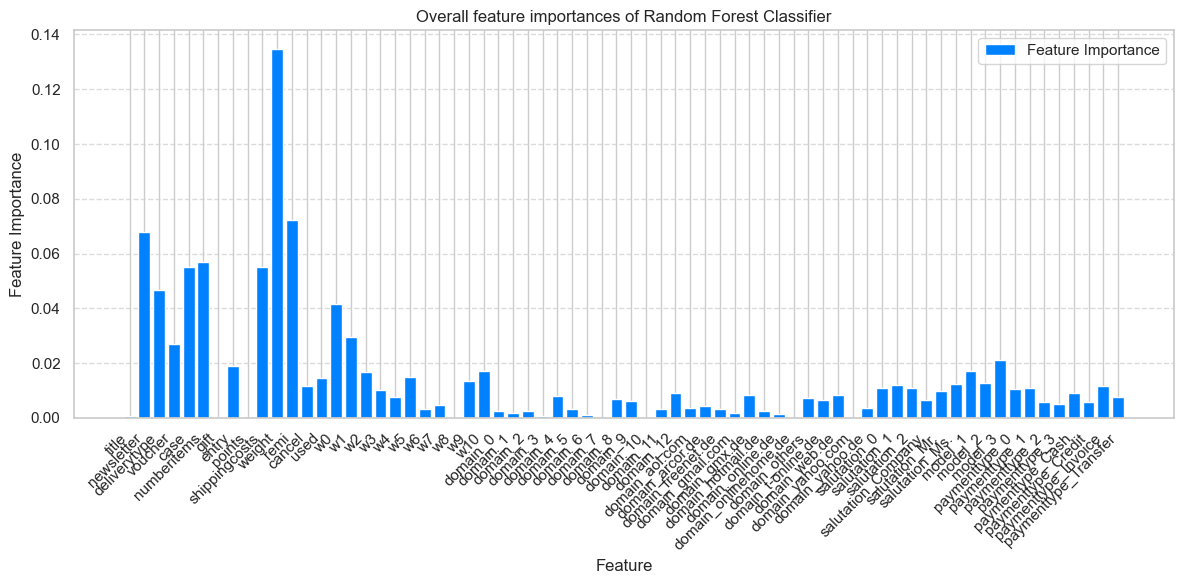

In [82]:
# Set model to best estimator from CV
model = forest_cv2.best_estimator_

# Plot feature importance
fig = plt.figure(figsize=(12, 6))
ax = fig.gca() #get current axis
ax.bar(range(x_train.shape[1]), model.feature_importances_, color = "#0081ff", width = 0.8)
ax.set_xticks(np.arange(x_train.shape[1]))
ax.set_xticklabels([f'{col}' for col in x_train.columns], rotation=45, ha='right')
ax.set_xlabel('Feature', fontsize = 12)
ax.set_ylabel('Feature Importance', fontsize = 12)
ax.set_title('Overall feature importances of Random Forest Classifier')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(['Feature Importance'])
plt.tight_layout()
# plt.savefig('feature_importance.png', dpi=300)


- Permutation feature importance

In [83]:
# Set list of metrics to compute feature importance for
metrics = ['accuracy', 'precision', 'recall', 'f1'] # specificity not a valid scoring metric
# Initialize empty dictionary to store results
pfi_scores = {}
# Loop over all metrics
for metric in metrics: 
    print('Computing permutation importance with {0}...'.format(metric))
    pfi_scores[metric] = permutation_importance(model, x_test, y_test, scoring = metric, n_repeats = 30, random_state = seed)

Computing permutation importance with accuracy...
Computing permutation importance with precision...
Computing permutation importance with recall...
Computing permutation importance with f1...


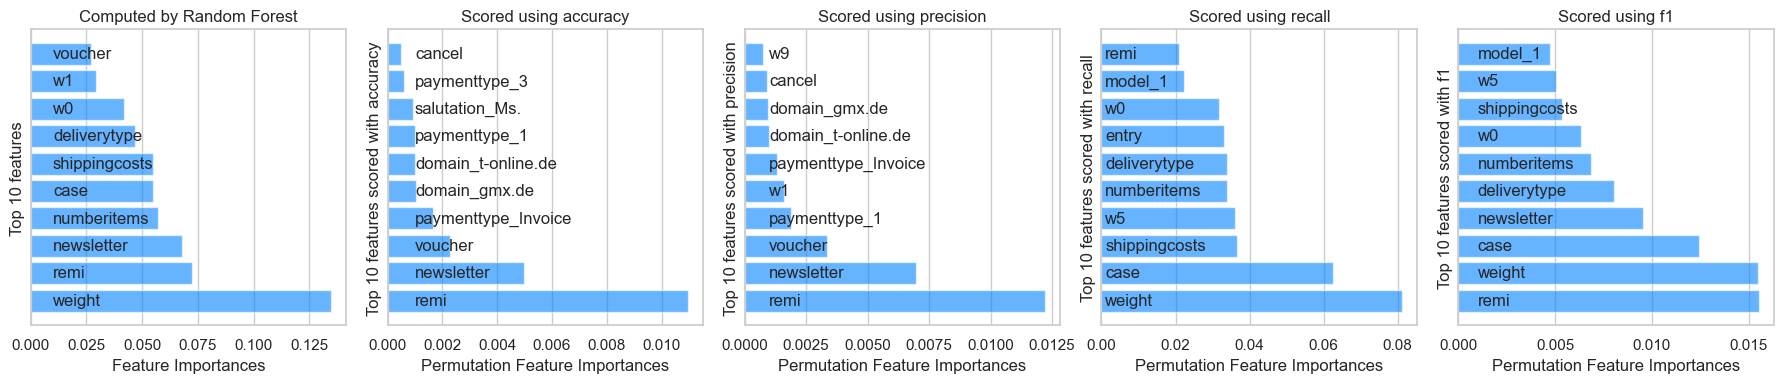

In [84]:
# Visualization of results 
features = x_test.columns.values
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (18, 4))

scores = model.feature_importances_
features = x_test.columns.to_numpy()
srtd = np.argsort(-scores) # sort descending and get indices

top = 10 # Top 10 features
ax[0].barh(y = np.arange(0, top), width=scores[srtd[:top]], color='#0081ff', alpha = 0.6) # regular feature importance of RF 
for i in range(top):
    ax[0].text(0.01, i-0.15, features[srtd[i]]) # add feature names to plot
ax[0].set_yticks([])
ax[0].set_ylabel('Top {0} features'.format(top));
ax[0].set_xlabel('Feature Importances')
ax[0].set_title('Computed by Random Forest')

for k, metric in enumerate(metrics):
    scores = pfi_scores[metric]['importances_mean']
    srtd = np.argsort(-scores)
    
    ax[k+1].barh(y=np.arange(0, top), width = scores[srtd[:top]], color = '#0081ff', alpha = 0.6)
    for i in range(top):
        ax[k+1].text(0.001, i-0.15, features[srtd[i]])
    ax[k+1].set_yticks([])
    ax[k+1].set_ylabel('Top {0} features scored with {1}'.format(top, metric));
    ax[k+1].set_xlabel('Permutation Feature Importances')
    ax[k+1].set_title('Scored using {0}'.format(metric))

plt.tight_layout()

##### Global model agnostic methods

- Partial dependence plots

In [85]:
continuous_features = ["numberitems", "weight", "remi", "cancel", "used", "w0", "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10", ]
ordinal_features = ["case"]
binary_features = ["title", "newsletter", "deliverytype", "voucher", "domain_aol.com", "domain_arcor.de", "domain_freenet.de", "domain_gmail.com", "domain_gmx.de",
                    "domain_hotmail.de", "domain_online.de", "domain_onlinehome.de", "domain_t-online.de", "domain_web.de", "domain_yahoo.com", "domain_yahoo.de", "domain_others",
                    "salutation_Company", "salutation_Mr.", "salutation_Ms.", "model_1", "model_2", "model_3", "paymenttype_Cash", "paymenttype_Credit",
                      "paymenttype_Invoice", "paymenttype_Transfer"]

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


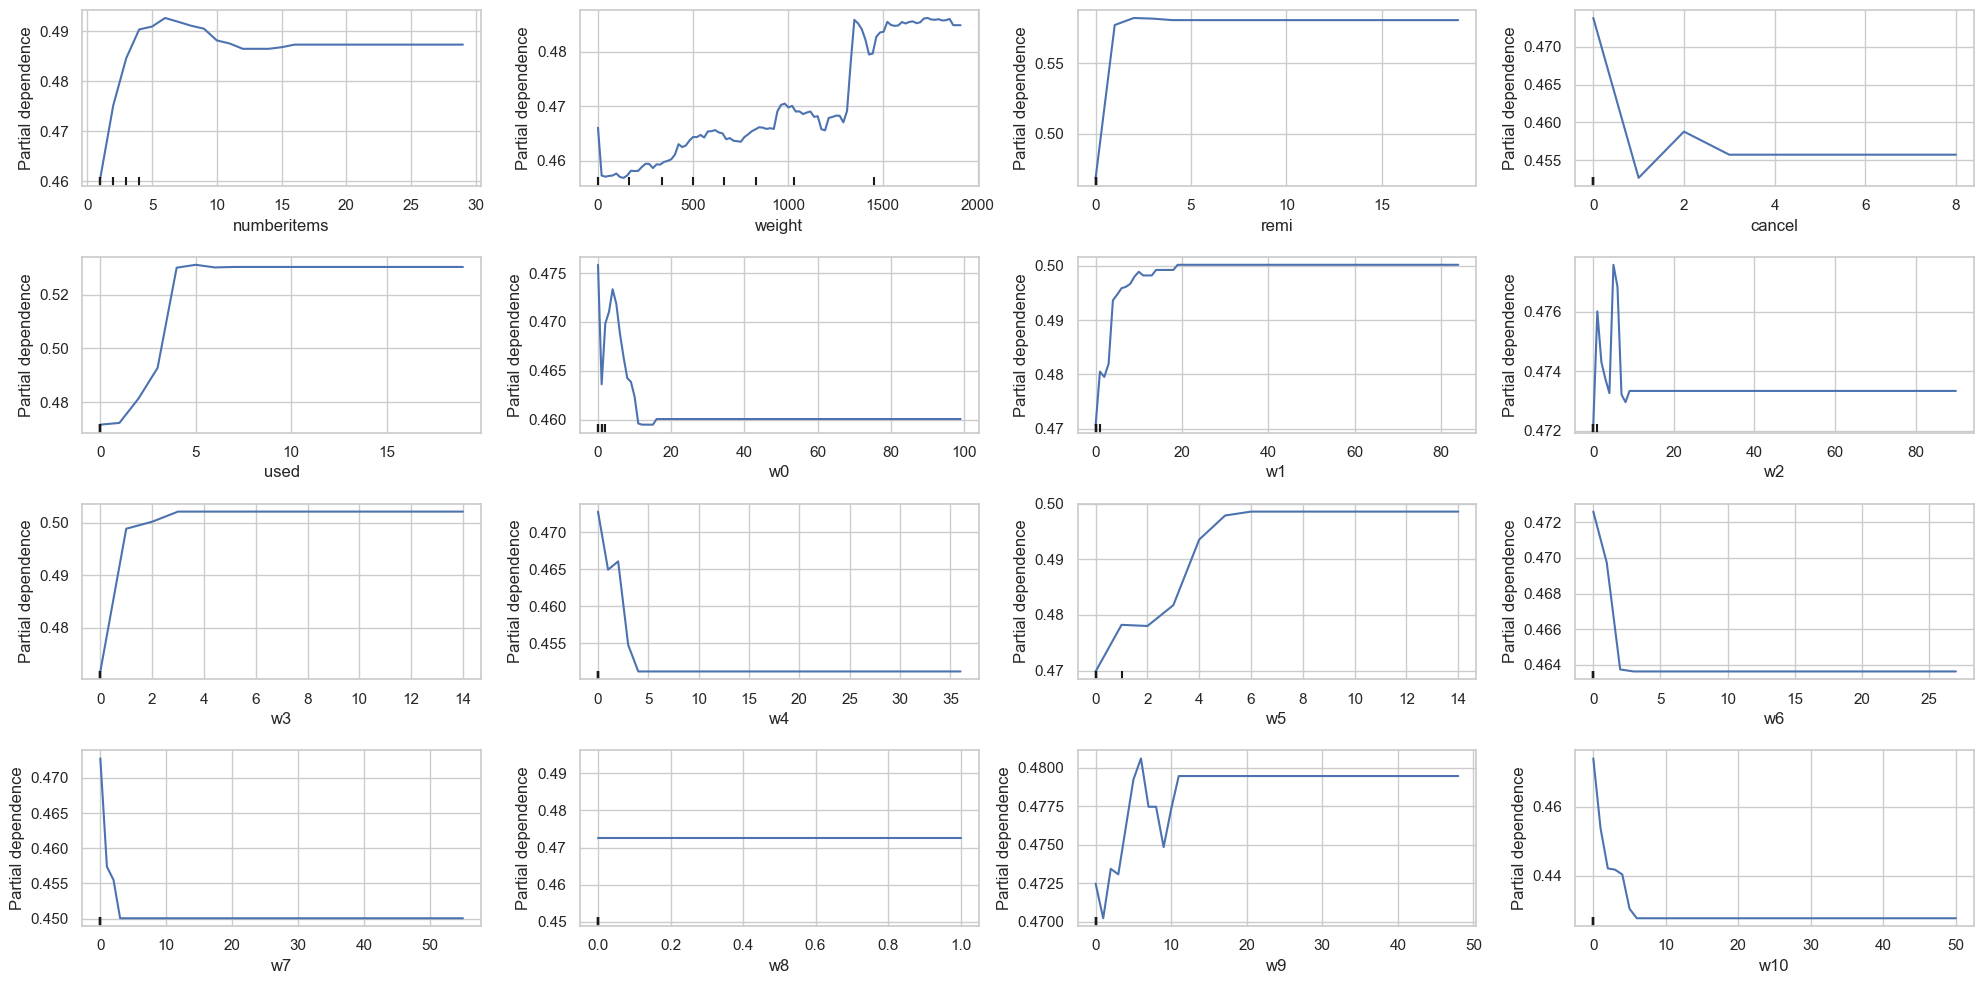

In [86]:
# Continuous features
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))

# Iterate through both features and axes
for feature, axis in zip(continuous_features, ax.flatten()):
    pdp.from_estimator(forest_cv2.best_estimator_, x_train,
                       features=[feature],  # Use only one feature at a time
                       feature_names=list(x_train.columns),
                       kind='average', 
                       response_method = "predict_proba", # Use predict_proba to get probability of class 1
                       ax=axis)

    # Set the title for each subplot
    # axis.set_title(feature, fontsize = 12)

plt.tight_layout()
plt.show()

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


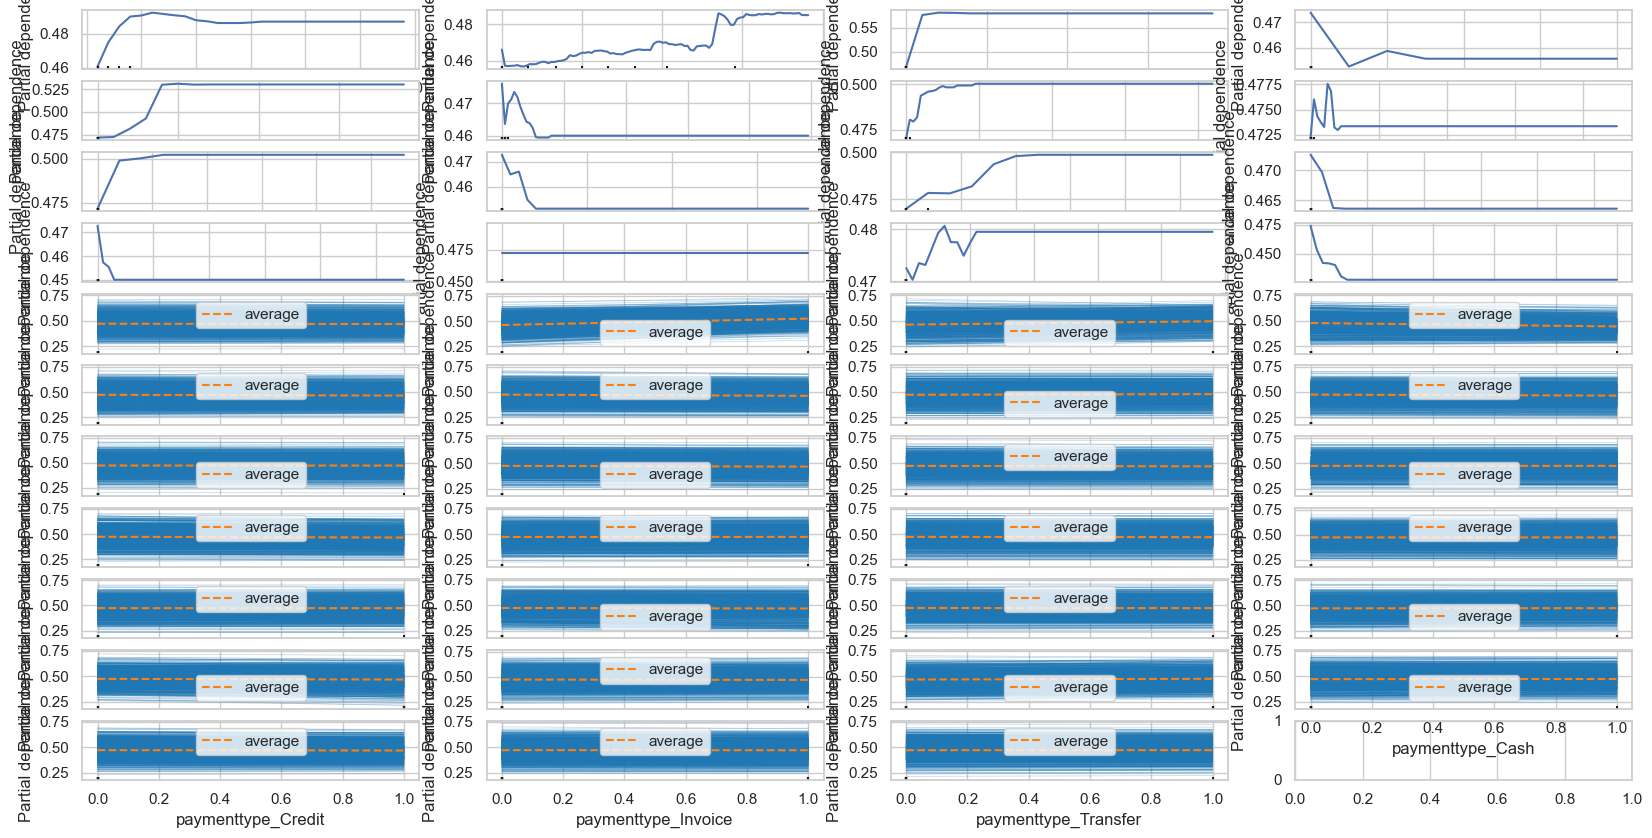

In [87]:
fig, ax = plt.subplots(nrows=11, ncols=4, figsize=(20, 10))
# Iterate through both continuous and binary features and axes
for feature, axis in zip(continuous_features + binary_features, ax.flatten()):
    # Check if the feature is continuous or binary
    if feature in continuous_features:
        pdp.from_estimator(forest_cv2, x_train,
                           features=[feature],
                           feature_names=list(x_train.columns),
                           kind='average', 
                           response_method="predict_proba",
                           ax=axis)
    else:  # Binary features
        pdp.from_estimator(forest_cv2, x_train,
                           features=[feature],
                           feature_names=list(x_train.columns),
                           kind='both',  
                           response_method="predict_proba",
                           ax=axis)

    # Set the title for each subplot
    #axis.set_title(feature, fontsize=12)

- Global surrogate model

In [88]:
# Compute the model
yb_train_pred = forest_cv2.predict(x_train)  # Training set predictions of the black-box (RF) model
yb_test_pred = forest_cv2.predict(x_test)  # Test set predictions of the black-box (RF) model

acc={}

# Loop over max_depth
depth_limits = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for max_depth in depth_limits:
    print('Surrogate max-depth = {0}'.format(max_depth))
    surrogate = DecisionTreeClassifier(max_depth = max_depth, criterion = 'gini', 
                                       min_samples_leaf = 20, class_weight = 'balanced', random_state = seed)
    surrogate.fit(x_train, yb_train_pred)
    ys_train_pred = surrogate.predict(x_train)
    ys_test_pred = surrogate.predict(x_test)
       
    acc[max_depth] = {'trn': {'black-box': accuracy_score(y_train, yb_train_pred),
                                   'surrogate': accuracy_score(y_train, ys_train_pred),
                                   'r2': r2_score(yb_train_pred, ys_train_pred)},
                           'tst': {'black-box': accuracy_score(y_test, yb_test_pred),
                                   'surrogate': accuracy_score(y_test, ys_test_pred),
                                   'r2': r2_score(yb_test_pred, ys_test_pred)}} # r_squared as in regression 

Surrogate max-depth = 2
Surrogate max-depth = 3
Surrogate max-depth = 4
Surrogate max-depth = 5
Surrogate max-depth = 6
Surrogate max-depth = 7
Surrogate max-depth = 8
Surrogate max-depth = 9
Surrogate max-depth = 10


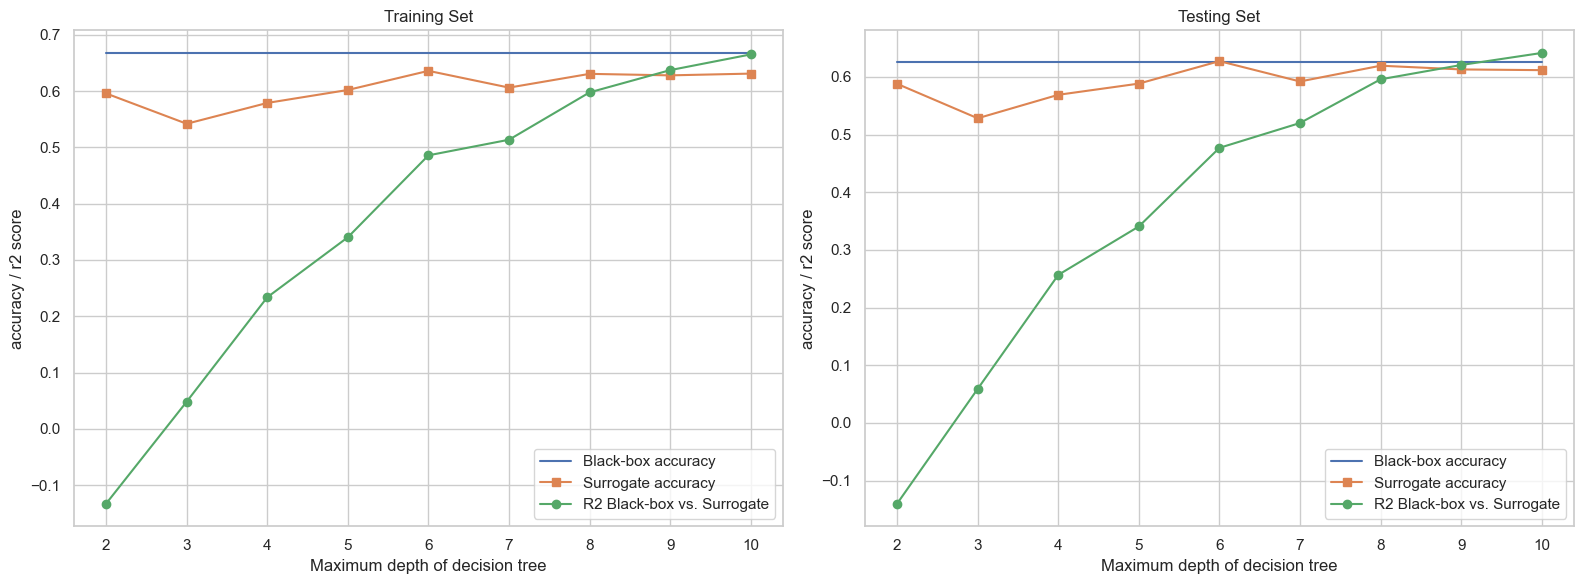

In [89]:
# Visualization of results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

fig_labels = ['Training Set', 'Testing Set']
markers = [None, 's', 'o']
for i, dset in enumerate(['trn', 'tst']):
    for j, curve in enumerate(['black-box', 'surrogate', 'r2']):
        z = [acc[mleaf][dset][curve] for mleaf in depth_limits]
        ax[i].plot(depth_limits, z, marker=markers[j])
    ax[i].legend(['Black-box accuracy', 'Surrogate accuracy', 'R2 Black-box vs. Surrogate'])
    ax[i].set_title(fig_labels[i])
    ax[i].set_xlabel('Maximum depth of decision tree')
    ax[i].set_ylabel('accuracy / r2 score')
    ax[i].set_xticks(depth_limits)
plt.tight_layout()

Visual inspection of the graphs above suggests that a maximum depth of 6 seems to be an adequate parameter value. Here, the model performs well enough while still being rather easy to interpret.

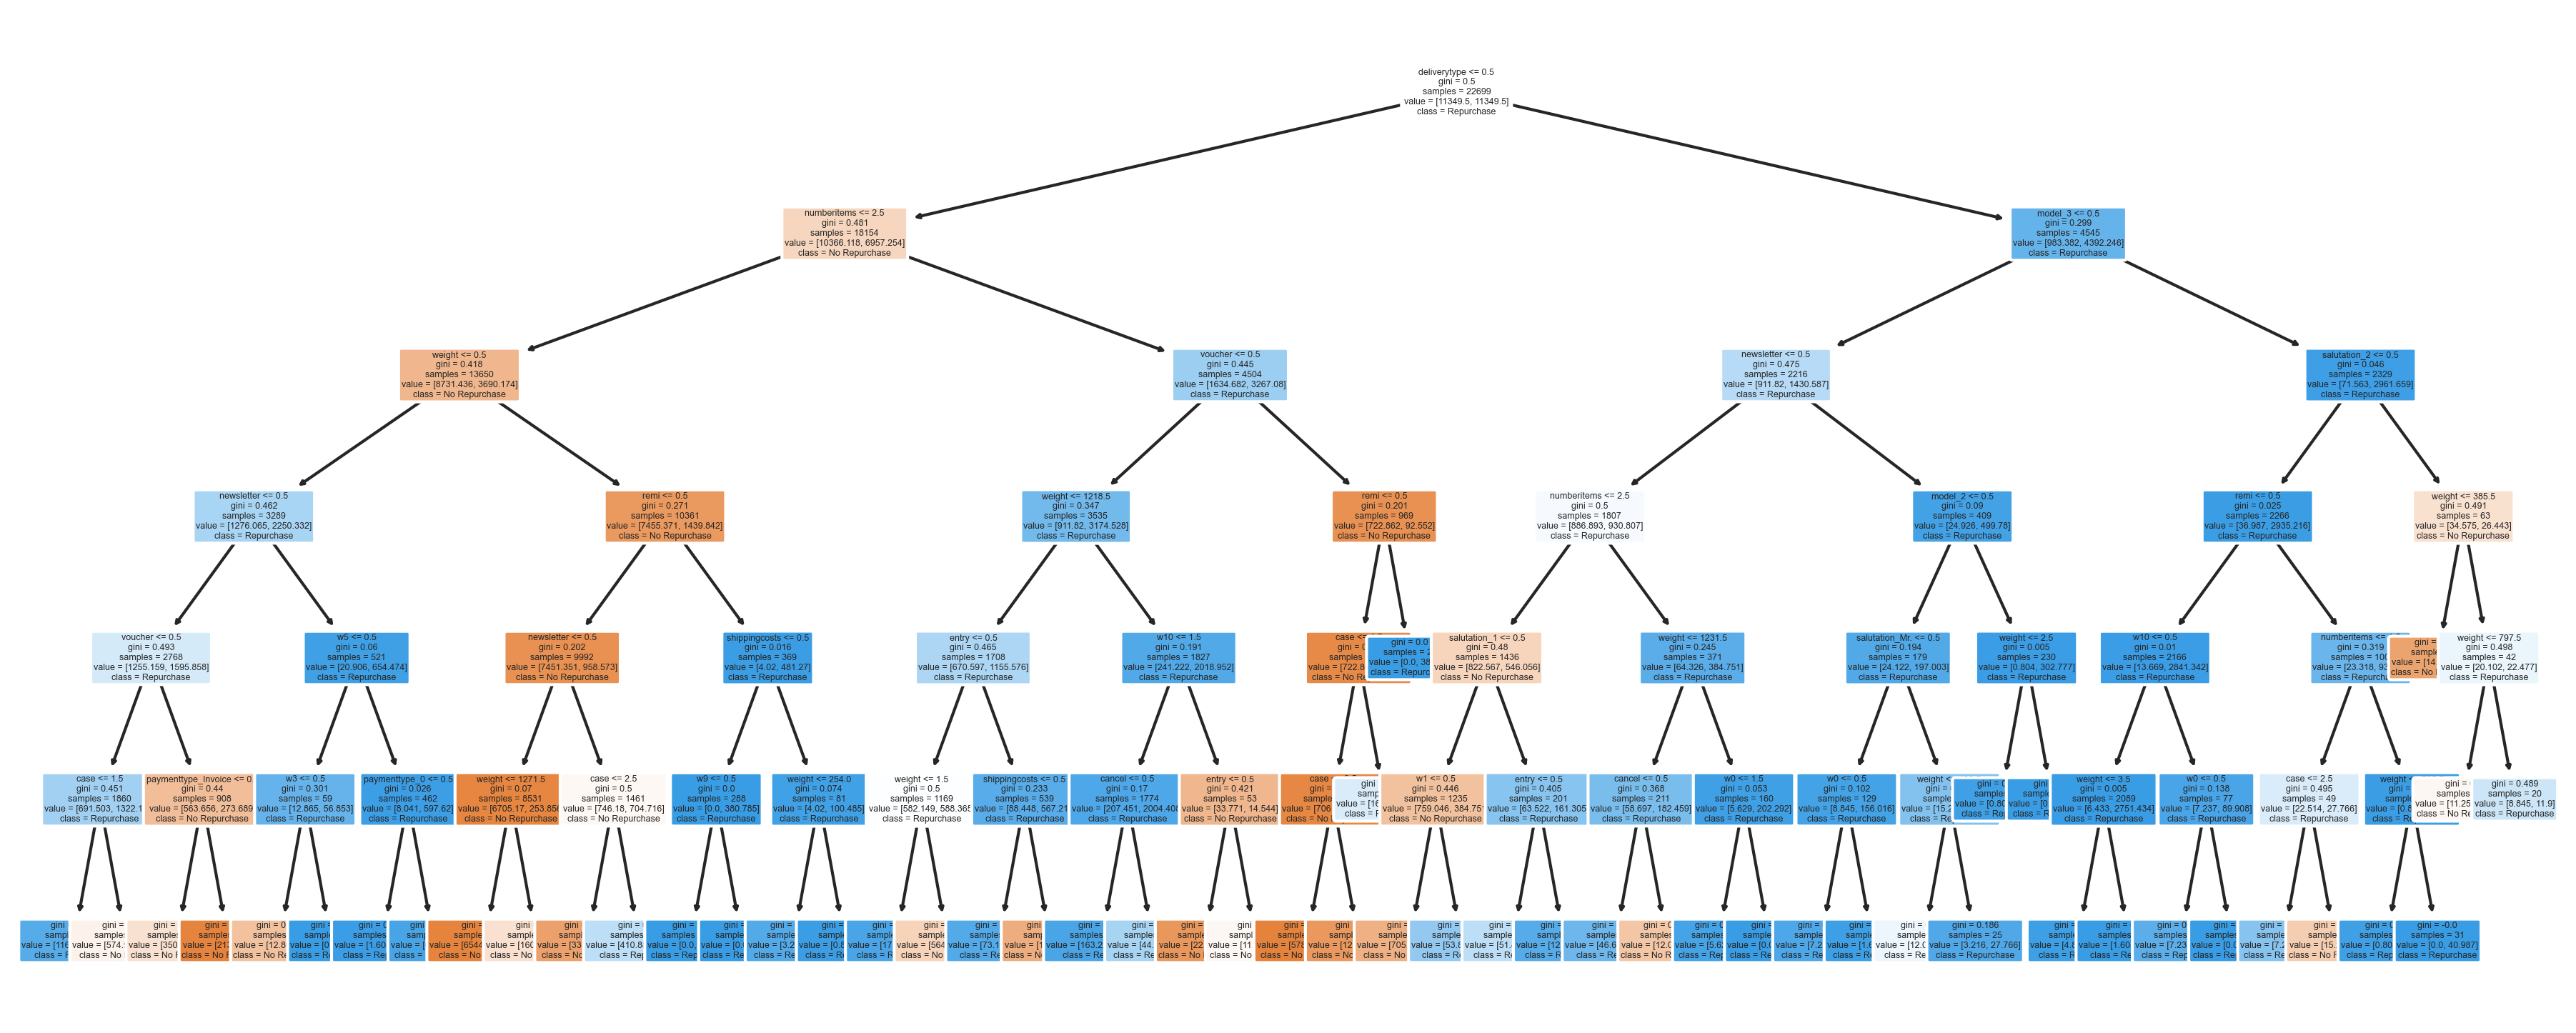

In [90]:
# Set up surrogate model as decision tree with max_depth = 6
surrogate = DecisionTreeClassifier(max_depth = 6, criterion = 'gini', min_samples_leaf = 20, class_weight = 'balanced', random_state = seed)
surrogate.fit(x_train, yb_train_pred)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()
plot_tree(surrogate, fontsize = 3, feature_names = x_train.columns.values, 
          rounded=True, filled=True, ax = ax, class_names = ["No Repurchase", "Repurchase"]) # in order of surrogate.classes_
fig.savefig('Regression Tree.PNG')

##### Local model agnostic methods (LIME)

- Explain one prediction instance of our trained model

In [100]:
cat_features = ['title', 'newsletter', 'deliverytype', 'invoicepostcode', 'voucher',
                'case', 'gift', 'entry', 'points', 'shippingcosts', 'paymenttype',
                'salutation', 'delay']

cat_idx = np.array([cat_features.index(f) for f in cat_features])


lime_explainer = lime_tabular.LimeTabularExplainer(x_train.values,
                                              feature_names=list(x_train.columns), 
                                              class_names=['No purchase', 'Repurchase'], 
                                              categorical_features=cat_idx,
                                              kernel_width=75.0,
                                              categorical_names=cat_features,
                                              discretize_continuous=False)

In [103]:
# Explain a single instance using example index:
exp = lime_explainer.explain_instance(x_test.iloc[3000], forest_cv2.predict_proba)
exp.show_in_notebook(show_table=False, show_all=False)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


- Shapley values 

In [93]:
shap_explainer = shap.Explainer(forest_cv2.best_estimator_)
shap_values = shap_explainer.shap_values(x_test)

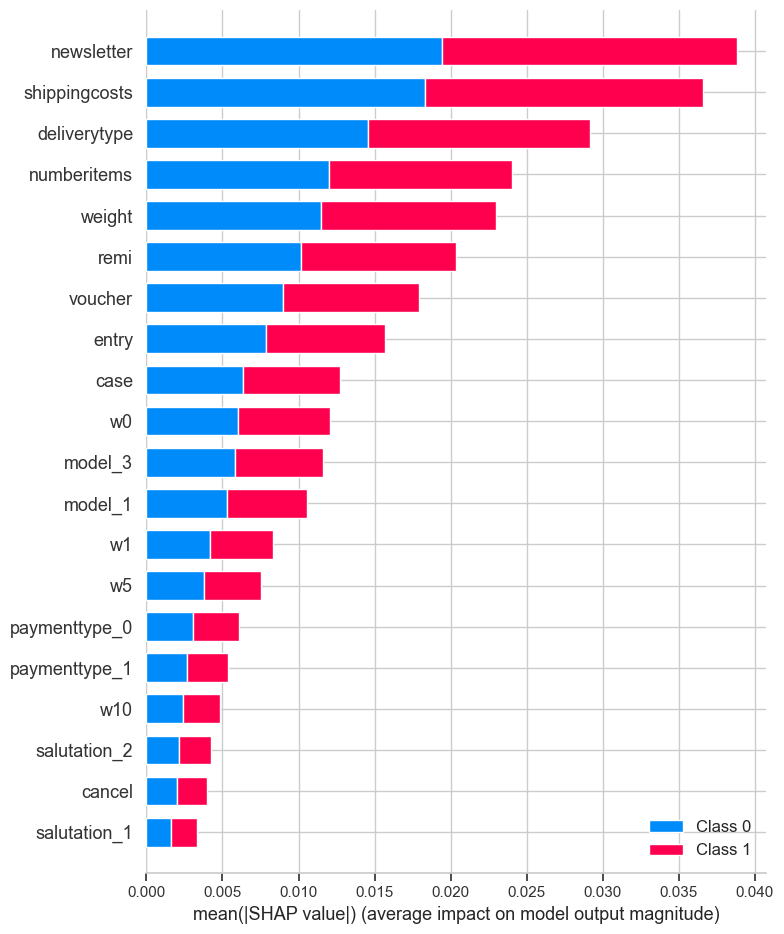

In [94]:
shap.summary_plot(shap_values, x_test)

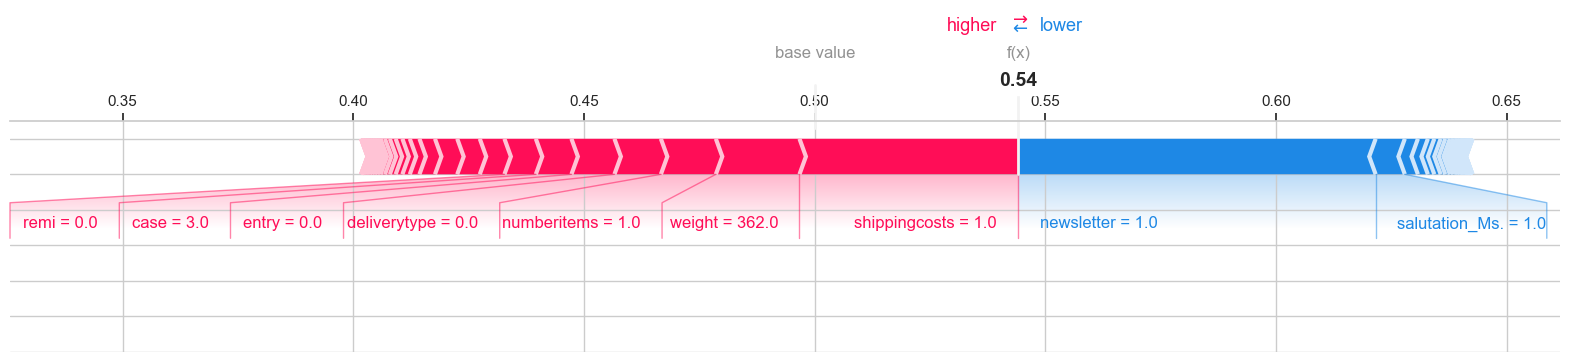

In [95]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], x_test.iloc[0, :], matplotlib = True)

https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

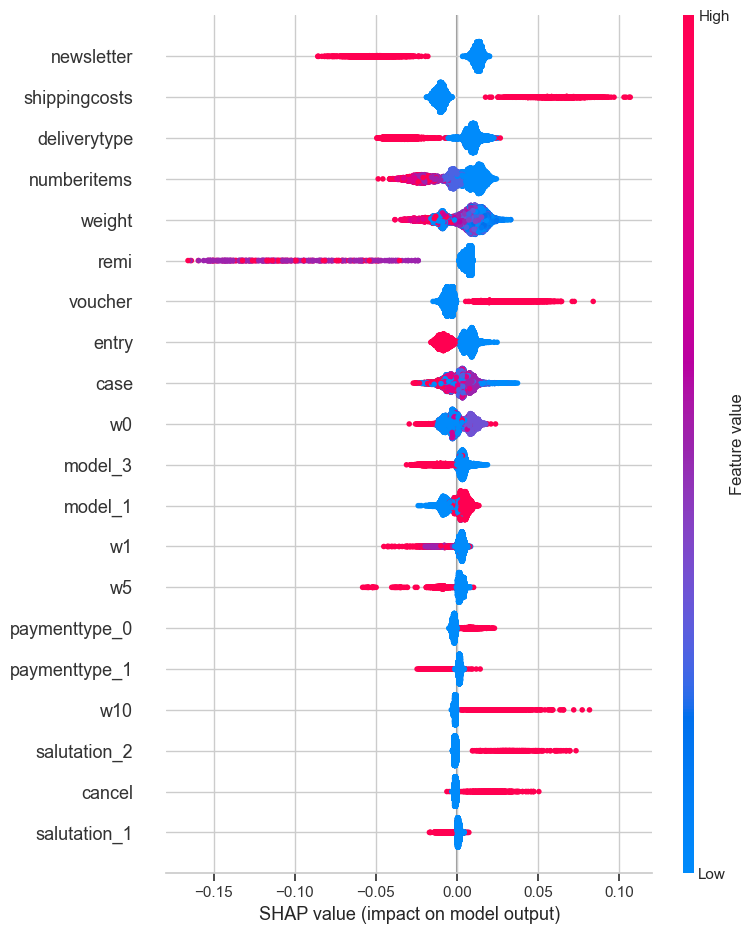

In [96]:
shap.summary_plot(shap_values[0], x_test)

An increasing number of remitted items, as well as not being subscribed to the newsletter for example has a negative influence on the repurchase probability. 